# Change network depth of Levi Hassner Model for Gender Classification on Adience Dataset

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print(tf.__version__)

/mnt/local/yuxin/anaconda3/envs/gender/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-09 20:10:01.414211: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


# Preprocess Adience Dataset

In [4]:
# load data
ADIENCE_PATH = './Adience'
print(os.listdir(path=ADIENCE_PATH))

all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )

['AdienceBenchmarkGenderAndAgeClassification', 'faces', 'fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt', '__MACOSX']


In [5]:
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [6]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


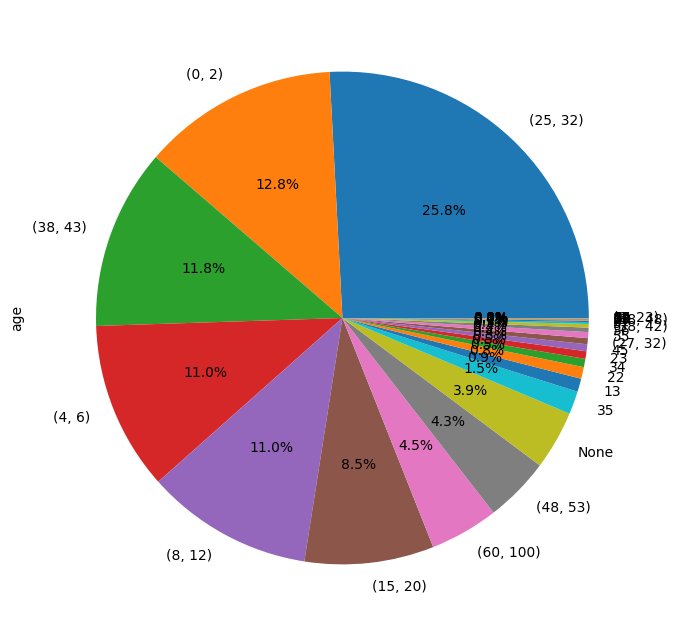

In [7]:
# pie_graph
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

f    9372
m    8120
u    1099
Name: gender, dtype: int64


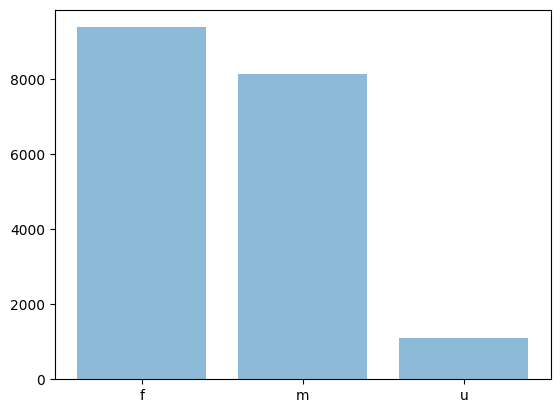

In [8]:
# bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
print(total_data.gender.value_counts())
plt.show()

In [9]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   x         19370 non-null  int64 
 3   y         19370 non-null  int64 
 4   dx        19370 non-null  int64 
 5   dy        19370 non-null  int64 
 6   img_path  19370 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


In [10]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

/tmp/ipykernel_16769/3604610946.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = age_mapping_dict[each]


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [11]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [12]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,./Adience/faces/30601258@N03/coarse_tilt_align...
1,4,1,301,105,640,641,./Adience/faces/30601258@N03/coarse_tilt_align...
2,4,0,2395,876,771,771,./Adience/faces/30601258@N03/coarse_tilt_align...
3,4,1,752,1255,484,485,./Adience/faces/30601258@N03/coarse_tilt_align...
4,4,1,175,80,769,768,./Adience/faces/30601258@N03/coarse_tilt_align...


# Create Dataset

In [13]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [14]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    # TODO: np.float
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


# Create Model
---
## Hyperparameters

In [15]:
batch_size = 1
epochs = 500
target_size = (227, 227) # (64, 64)
input_shape = (227, 227, 3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre = -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 256
validation_steps = 256

In [17]:
# calculate schedule drop based on epoch supplied
# paper said drop to 1e-4 when 10k epochs which is equivalent to drop 1e-3 by 10% which is 1e-4
import math

def step_decay(epoch):
    init_lrate = 1e-3 
    drop = 0.1
    epochs_drop = 10000
    lrate = init_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
    
weight_init = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=SEED)

## 4conv + 4fc

In [21]:
# Define baseline model builder
def adapt_LeviHassner():
    model = keras.models.Sequential()
    
    # conv1: 96 filters, 7x7 kernel, stride=4, valid padding
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(96, (7,7), input_shape=input_shape, strides=4, padding='valid', 
                     activation='relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv2: 256 filters, 5x5 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(256, (5,5), padding='same', activation = 'relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2,padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv3: 384 filters, 3x3 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    model.add(Conv2D(384,(3,3),padding='same',activation='relu',kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # add conv4: 512 filters, 3x3 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    model.add(Conv2D(512,(3,3),padding='same',activation='relu',kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
    
    
    # flatten
    model.add(Flatten())
    
    # fc1 + dropout
    model.add(Dense(512, activation="relu", kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # fc2 + dropout
    model.add(Dense(512, activation='relu', kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # add fc3 + dropout
    model.add(Dense(512, activation='relu', kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # fc4
    model.add(Dense(1, activation ='sigmoid', kernel_initializer=weight_init))
    
    # compile the model
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 384)      

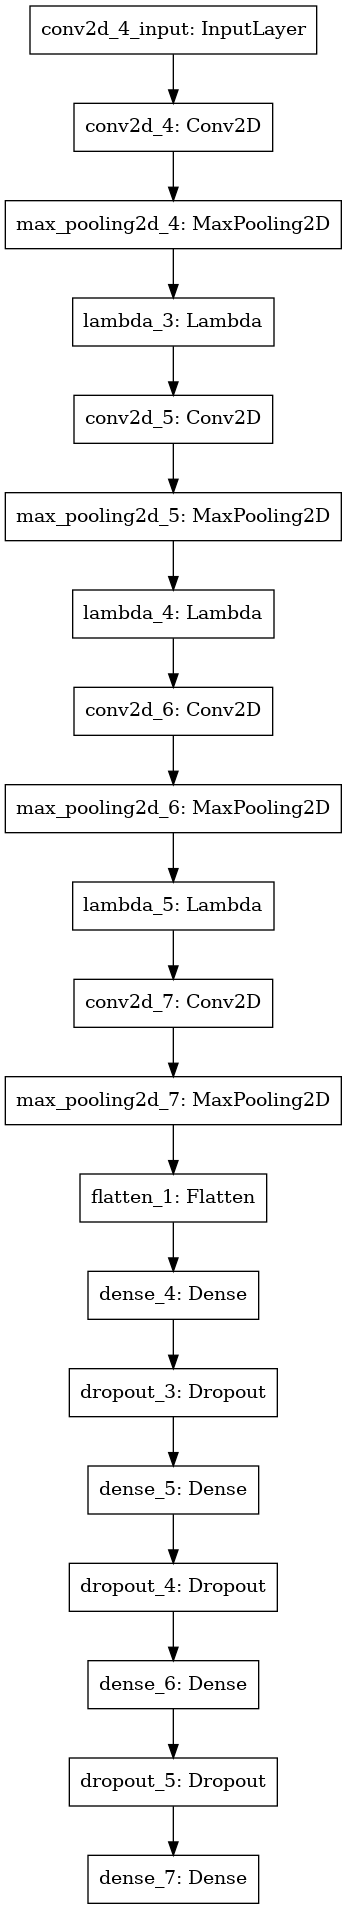

In [22]:
# Visualize the model
from tensorflow.keras.utils import plot_model

model = adapt_LeviHassner()
model.summary()
plot_model(model)

In [23]:
def get_call_backs():
    """
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)
    """
    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    
    mcp = ModelCheckpoint('model.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrate, mcp, es]

In [24]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [25]:
# training
history = model.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

2022-11-09 20:24:08.493611: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.
2022-11-09 20:24:09.046561: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-09 20:24:09.064871: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz


Epoch 1/500


2022-11-09 20:24:09.336343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-09 20:24:09.458056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-09 20:24:10.094162: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-11-09 20:24:10.197484: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:10.197574: W tensorflow/str

2022-11-09 20:24:12.707831: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:12.810729: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:12.915054: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:13.022349: W tensorflow/stream_executor/gpu/

2022-11-09 20:24:15.656434: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:15.762586: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:15.867038: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:15.971067: W tensorflow/stream_executor/gpu/

2022-11-09 20:24:18.601210: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:18.705149: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:18.809512: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:18.916015: W tensorflow/stream_executor/gpu/

2022-11-09 20:24:21.529168: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:21.632387: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:21.737905: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:21.844580: W tensorflow/stream_executor/gpu/

   12/12216 [..............................] - ETA: 56s - loss: 0.6936 - accuracy: 0.4640         

2022-11-09 20:24:22.163182: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 20:24:22.268316: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



12208/12216 [============================>.] - ETA: 0s - loss: 0.6913 - accuracy: 0.5343

2022-11-09 20:25:07.312322: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 809417532 exceeds 10% of free system memory.


12216/12216 [==============================] - 66s 4ms/step - loss: 0.6913 - accuracy: 0.5343 - val_loss: 0.6922 - val_accuracy: 0.5241
Epoch 2/500
12216/12216 [==============================] - 53s 4ms/step - loss: 0.6893 - accuracy: 0.5447 - val_loss: 0.6919 - val_accuracy: 0.5241
Epoch 3/500
12216/12216 [==============================] - 53s 4ms/step - loss: 0.6903 - accuracy: 0.5352 - val_loss: 0.6885 - val_accuracy: 0.5397
Epoch 4/500
12216/12216 [==============================] - 53s 4ms/step - loss: 0.6866 - accuracy: 0.5506 - val_loss: 0.6841 - val_accuracy: 0.5464
Epoch 5/500
12216/12216 [==============================] - 54s 4ms/step - loss: 0.6718 - accuracy: 0.5858 - val_loss: 0.6464 - val_accuracy: 0.6555
Epoch 6/500
12216/12216 [==============================] - 53s 4ms/step - loss: 0.6392 - accuracy: 0.6454 - val_loss: 0.5792 - val_accuracy: 0.7032
Epoch 7/500
12216/12216 [==============================] - 54s 4ms/step - loss: 0.5948 - accuracy: 0.6919 - val_loss: 0.5138

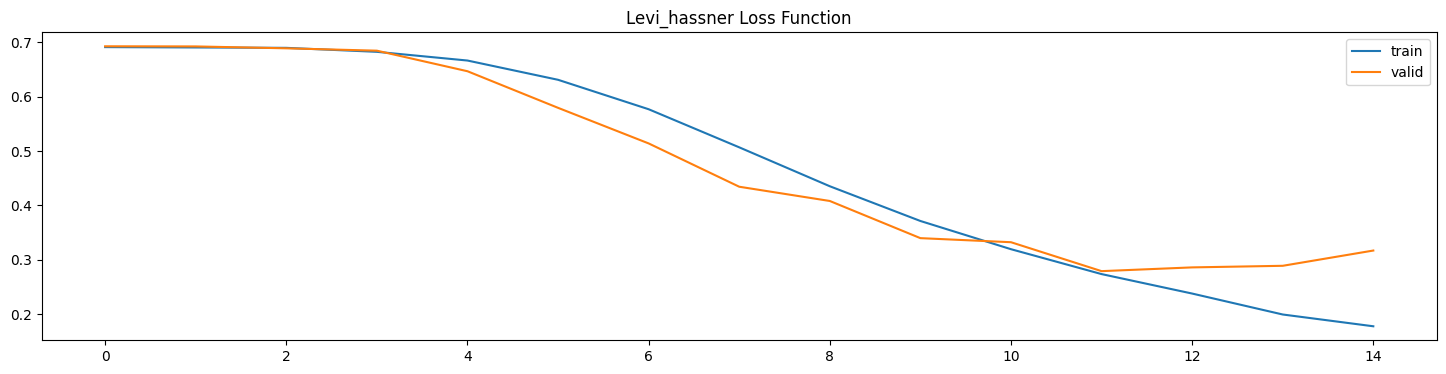

In [26]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Levi_hassner Loss Function')
plt.show()

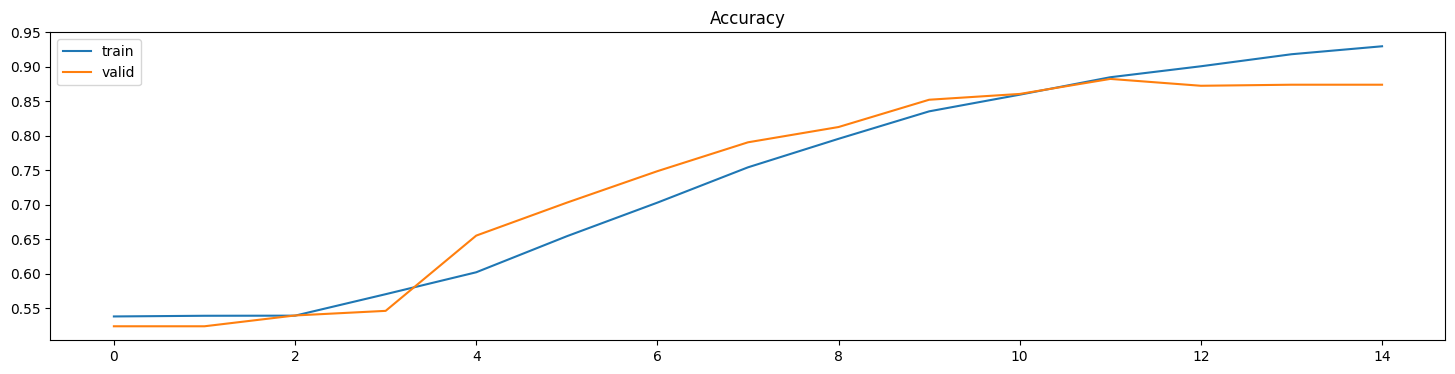

In [27]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [29]:
# test
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

2022-11-09 20:39:55.520405: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 809417532 exceeds 10% of free system memory.


164/164 - 1s - loss: 0.3172 - accuracy: 0.8741
0.8741405606269836


### 2conv + 2fc

In [30]:
# Define baseline model builder
def adapt_LeviHassner_shadow():
    model = keras.models.Sequential()
    
    # conv1: 96 filters, 7x7 kernel, stride=4, valid padding
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(96, (7,7), input_shape=input_shape, strides=4, padding='valid', 
                     activation='relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv2: 256 filters, 5x5 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(256, (5,5), padding='same', activation = 'relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2,padding = 'same'))

    # flatten
    model.add(Flatten())
    
    # fc1 + dropout
    model.add(Dense(512, activation="relu", kernel_initializer=weight_init))
    model.add(Dropout(0.5))
     
    # fc2
    model.add(Dense(1, activation ='sigmoid', kernel_initializer=weight_init))
    
    # compile the model
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)              

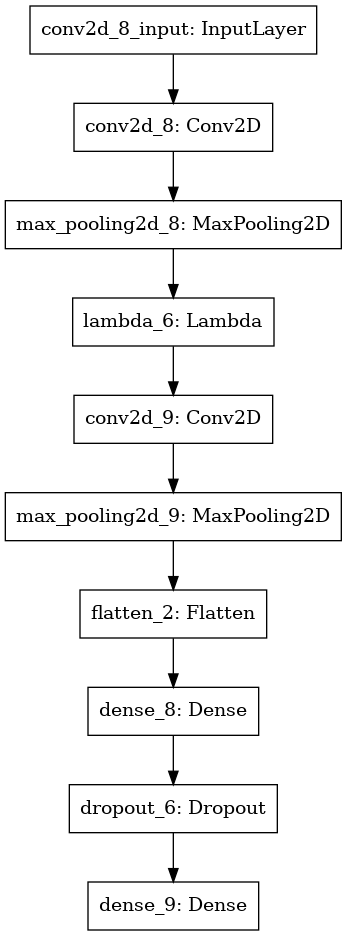

In [31]:
# Visualize the model
from tensorflow.keras.utils import plot_model

model_ = adapt_LeviHassner_shadow()
model_.summary()
plot_model(model_)

In [32]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [33]:
# training
history = model_.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

Epoch 1/500
    1/12216 [..............................] - ETA: 35:48 - loss: 0.3697 - accuracy: 1.0000

2022-11-09 20:47:47.610879: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.


12216/12216 [==============================] - 41s 3ms/step - loss: 0.7545 - accuracy: 0.5409 - val_loss: 0.6531 - val_accuracy: 0.6175
Epoch 2/500
12216/12216 [==============================] - 40s 3ms/step - loss: 0.6718 - accuracy: 0.5813 - val_loss: 0.6125 - val_accuracy: 0.6648
Epoch 3/500
12216/12216 [==============================] - 41s 3ms/step - loss: 0.6367 - accuracy: 0.6328 - val_loss: 0.5849 - val_accuracy: 0.6866
Epoch 4/500
12216/12216 [==============================] - 41s 3ms/step - loss: 0.5979 - accuracy: 0.6699 - val_loss: 0.5837 - val_accuracy: 0.6807
Epoch 5/500
12216/12216 [==============================] - 41s 3ms/step - loss: 0.5615 - accuracy: 0.7037 - val_loss: 0.6112 - val_accuracy: 0.6663
Epoch 6/500
12216/12216 [==============================] - 41s 3ms/step - loss: 0.5367 - accuracy: 0.7237 - val_loss: 0.5059 - val_accuracy: 0.7441
Epoch 7/500
12216/12216 [==============================] - 41s 3ms/step - loss: 0.5207 - accuracy: 0.7348 - val_loss: 0.5108

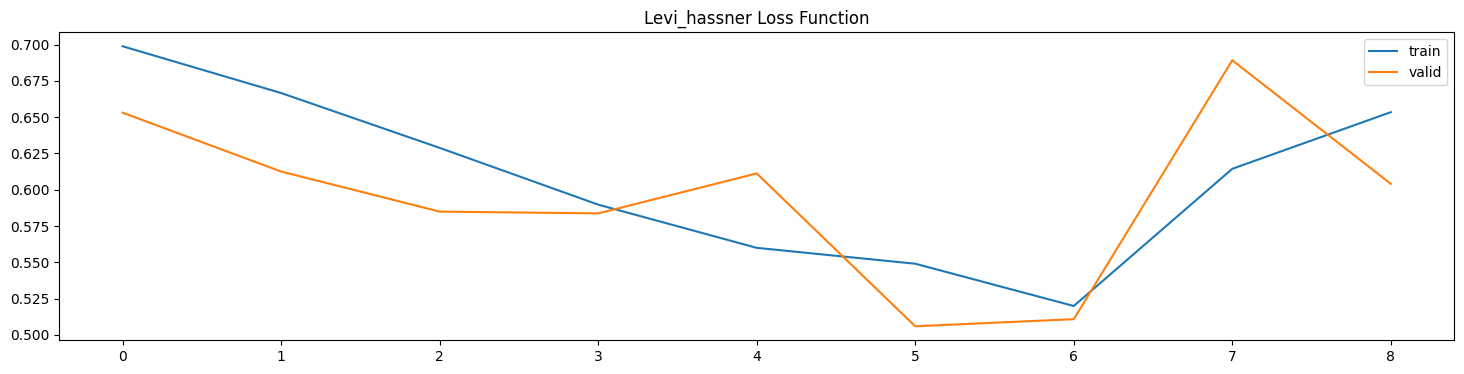

In [34]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Levi_hassner Loss Function')
plt.show()

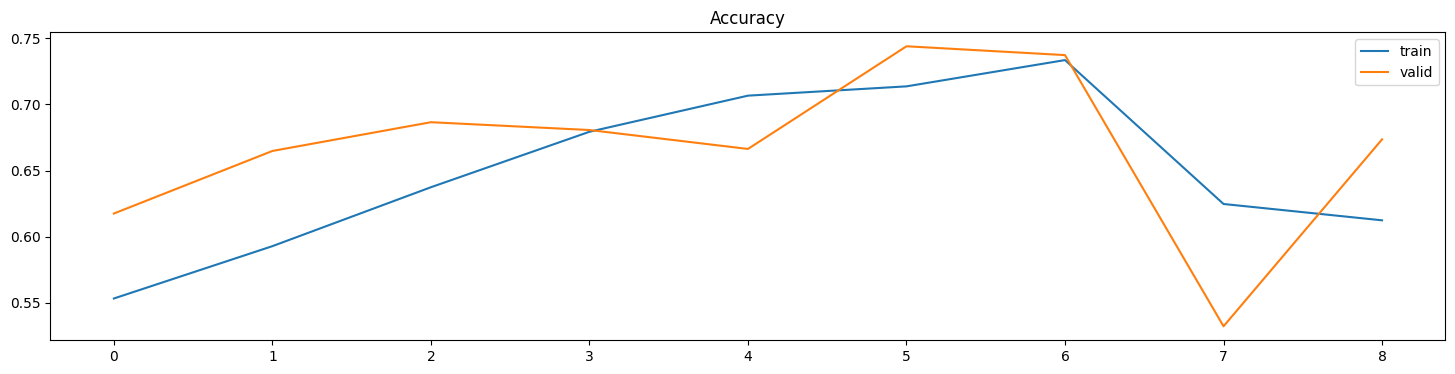

In [35]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [36]:
# test
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 1s - loss: 0.3172 - accuracy: 0.8741
0.8741405606269836
